In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

import time
import os
import matplotlib.pyplot as plt

import numpy as np

import pickle
import gzip

2024-11-03 08:15:47.354050: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-03 08:15:47.371879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730621747.393913    4260 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730621747.400492    4260 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 08:15:47.423150: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:

os.getcwd()

In [22]:
with gzip.open('../../result/one_hot_encoding/gene_id_label_ohe.pkl.gz', 'rb') as f:
    data = pickle.load(f)

In [3]:
data

,ensembl_gene_id,DE,upstream_region_encoded
0,ENSG00000000457,1,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
1,ENSG00000000460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0,..."
2,ENSG00000000938,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1,..."
3,ENSG00000000971,1,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0,..."
4,ENSG00000001460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."
...,...,...,...
55221,ENSG00000284520,0,"[[0, 0, 0, 1], [0, 1, 0, 0], [0, 0, 0, 1], [0,..."
55222,ENSG00000284544,0,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,..."
55223,ENSG00000284554,0,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1,..."
55224,ENSG00000284568,0,"[[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."


## Quality Control

In [ ]:
data.loc[0, "upstream_region_encoded"].shape

In [ ]:
accum = 0

for i in range(len(data)):
    temp  = test.iloc[1][['upstream_region_encoded']]
    if temp["upstream_region_encoded"].shape != (2001, 4):
        accum += 1

    if accum == 0:
        print('All genes have the same dimension of one-hot-encoded upstream region.')
print(accum)

## Train-test Split

In [36]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=123)

In [37]:
train_data

,ensembl_gene_id,DE,upstream_region_encoded
20681,ENSG00000218672,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
46371,ENSG00000026559,1,"[[0, 0, 1, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0,..."
7859,ENSG00000234415,0,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [0,..."
12713,ENSG00000249441,0,"[[1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0,..."
32644,ENSG00000089250,0,"[[0, 1, 0, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,..."
...,...,...,...
54370,ENSG00000268461,0,"[[1, 0, 0, 0], [1, 0, 0, 0], [0, 1, 0, 0], [0,..."
17730,ENSG00000253015,0,"[[0, 0, 1, 0], [1, 0, 0, 0], [1, 0, 0, 0], [0,..."
28030,ENSG00000110375,0,"[[0, 0, 1, 0], [1, 0, 0, 0], [0, 0, 0, 1], [0,..."
15725,ENSG00000213500,0,"[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,..."


In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [38]:
sequences = train_data['upstream_region_encoded'].tolist()
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, dtype="int32")
# Create TensorFlow dataset
train_data = tf.data.Dataset.from_tensor_slices(padded_sequences)
train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [39]:

# class SequenceDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, dataframe, batch_size=128, sequence_column="upstream_region_encoded"):
#         self.dataframe = dataframe
#         self.batch_size = batch_size
#         self.sequence_column = sequence_column
#         self.indices = np.arange(len(dataframe))
    
#     def __len__(self):
#         # Number of batches per epoch
#         return int(np.floor(len(self.dataframe) / self.batch_size))

#     def __getitem__(self, index):
#         # Generate batch indices
#         batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
#         # Load and stack sequences for the batch
#         batch_sequences = np.stack(self.dataframe.iloc[batch_indices][self.sequence_column].values)

#         # Transpose each sequence to channels-last format
#         batch_sequences = np.transpose(batch_sequences, (1, 2, 0)) 
        
#         return batch_sequences

# # Initialize generator
# batch_size = 128
# sequence_generator = SequenceDataGenerator(train_data_shuffled, batch_size=batch_size)

# # Example: Access the first batch
# first_batch = sequence_generator[0]
# print("First batch shape:", first_batch.shape)

AttributeError: '_ShuffleDataset' object has no attribute 'iloc'

In [48]:
def build_generator(height=2001, width=4, batch_size=BATCH_SIZE, noise_dim=100):
    model = tf.keras.Sequential()
    
    # Start with a dense layer, which we'll reshape to the target shape
    model.add(layers.Dense(height * width * batch_size, input_dim=noise_dim, activation='relu'))
    model.add(layers.Reshape((sequence_length, depth, batch_size)))
    
    # Add additional layers if needed to increase complexity
    model.add(layers.Conv2DTranspose(64, (5, 1), strides=(2, 1), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(32, (5, 1), strides=(2, 1), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(depth, (5, 1), padding='same', activation='softmax'))  # Output depth channels

    return model

In [49]:
generator = build_generator()
generator.summary()

/home/ubuntu/miniconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1024512)        │   103,475,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 2001, 4, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 4002, 4, 64)    │        41,024 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4002, 4, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8004, 4, 32)    │        10,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8004, 4, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 8004, 4, 4)     │           644 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,528,036 (394.93 MB)

 Trainable params: 103,527,844 (394.93 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# def build_generator(sequence_length):
#     model = models.Sequential()
#     model.add(layers.Dense(128, input_dim=100, activation='relu'))
#     model.add(layers.Dense(sequence_length * 4, activation='softmax'))  # output should match one-hot size
#     model.add(layers.Reshape((sequence_length, 4)))  # Reshape to (sequence_length, 4) for one-hot
#     return model

In [50]:
def build_discriminator(sequence_length=2001, depth=4, batch_size=128):
    model = tf.keras.Sequential()

    # Input layer matching generator's output shape
    model.add(layers.Conv2D(64, (5, 1), strides=(2, 1), padding='same', input_shape=(sequence_length, depth, batch_size)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    # Additional convolutional layers for more complexity
    model.add(layers.Conv2D(128, (5, 1), strides=(2, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (5, 1), strides=(2, 1), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())

    # Flatten the output and add a dense layer for final classification
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # Binary output: real (1) or fake (0)

    return model

# Example usage
discriminator = build_discriminator()
discriminator.summary()

/home/ubuntu/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ubuntu/miniconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 1001, 4, 64)    │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 1001, 4, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 1001, 4, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 501, 4, 128)    │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 501, 4, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 501, 4, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 251, 4, 256)    │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 251, 4, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 251, 4, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 257024)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │       257,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,025 (1.93 MB)

 Trainable params: 504,129 (1.92 MB)

 Non-trainable params: 896 (3.50 KB)

In [51]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [52]:
@tf.function
def train_step(generator, discriminator, real_data, noise_dim):
    noise = tf.random.normal([real_data.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
# one_hot_encoded = np.array([
#     [1, 0, 0, 0],  # A
#     [0, 1, 0, 0],  # T
#     [0, 0, 1, 0],  # C
#     [0, 0, 0, 1],  # G
#     [1, 0, 0, 0]   # A
# ])

# # Mapping from index to nucleotide
# index_to_nucleotide = ['A', 'T', 'C', 'G']

# # Convert one-hot encoding back to sequence
# data['sequence'] = data['upstream_region_encoded'].apply(
#     lambda one_hot_encoded: ''.join([index_to_nucleotide[np.argmax(row)] for row in one_hot_encoded])
# )

In [53]:
gen_loss_list, disc_loss_list = [], []

def train_gan(generator, discriminator, dataset, epochs, noise_dim):
    for epoch in range(epochs):
        gen_loss_total, disc_loss_total = 0, 0

        for real_data in dataset:
            gen_loss, disc_loss = train_step(generator, discriminator, real_data, noise_dim)
            gen_loss_total += gen_loss
            disc_loss_total += disc_loss

        # Track average losses for each epoch
        gen_loss_list.append(gen_loss_total / len(dataset))
        disc_loss_list.append(disc_loss_total / len(dataset))

        print(f"Epoch {epoch+1}, Generator Loss: {gen_loss_list[-1]}, Discriminator Loss: {disc_loss_list[-1]}")

    # Plot the losses after training
    plot_loss(gen_loss_list, disc_loss_list)

def plot_loss(gen_loss_list, disc_loss_list):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss_list, label="Generator Loss")
    plt.plot(disc_loss_list, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Generator and Discriminator Loss Over Time")
    plt.show()

In [ ]:
# data = data[['ensembl_gene_id', 'sequence']]

In [56]:
import seaborn as sns

def visualize_generated_samples(generator, noise_dim, num_examples=5):
    noise = tf.random.normal([num_examples, noise_dim])
    generated_samples = generator(noise, training=False)

    # Loop over each generated sample
    for i in range(num_examples):
        sample = generated_samples[i].numpy()  # Shape: (sequence_length, depth, channels)

        plt.figure(figsize=(12, 4))
        # Loop through each channel (4 in this case if depth is 4)
        for j in range(sample.shape[-1]):
            plt.subplot(1, sample.shape[-1], j + 1)
            sns.heatmap(sample[:, :, j], cmap="viridis", cbar=False)
            plt.title(f"Sample {i+1}, Channel {j+1}")
            plt.xlabel("Depth")
            plt.ylabel("Sequence Length")

        plt.tight_layout()
        plt.show()

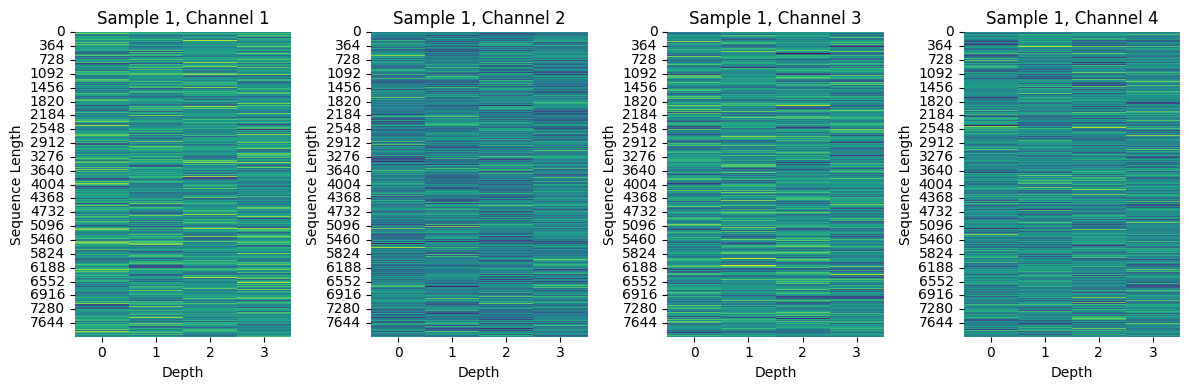

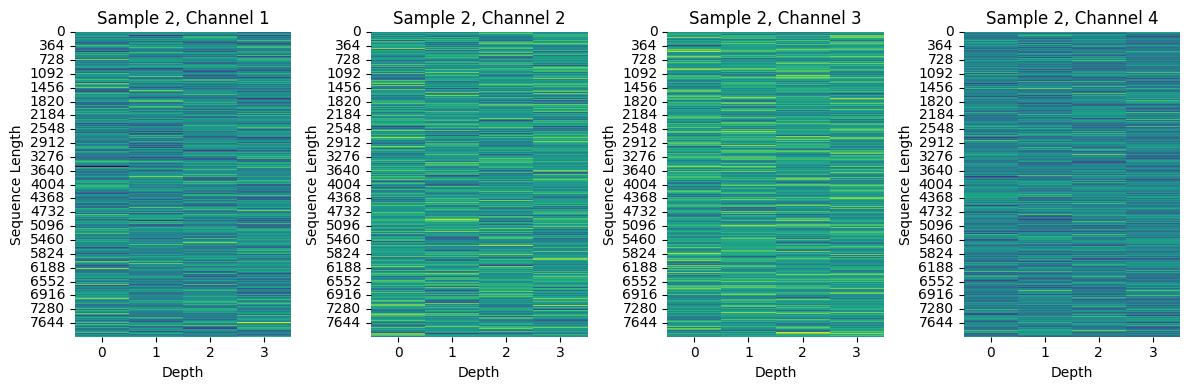

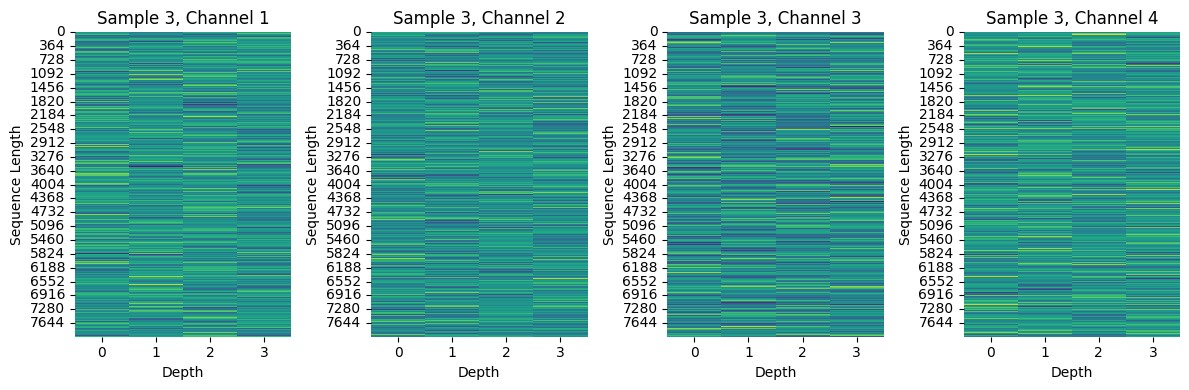

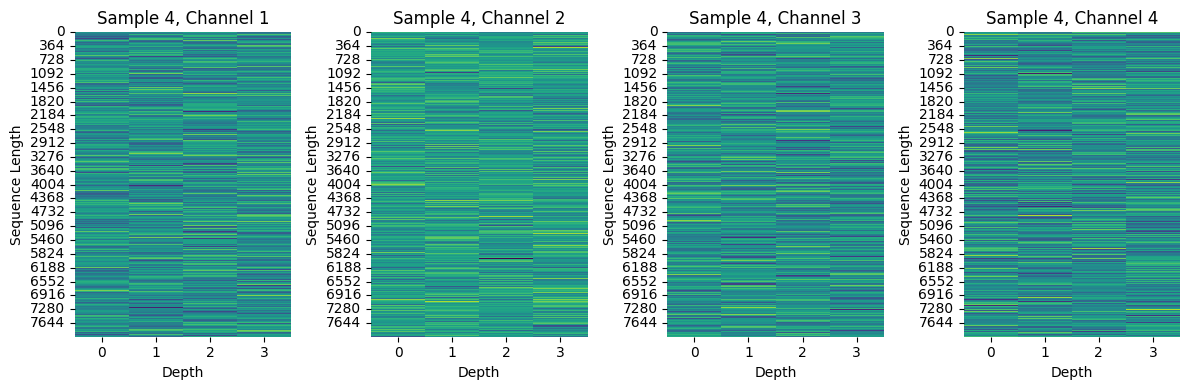

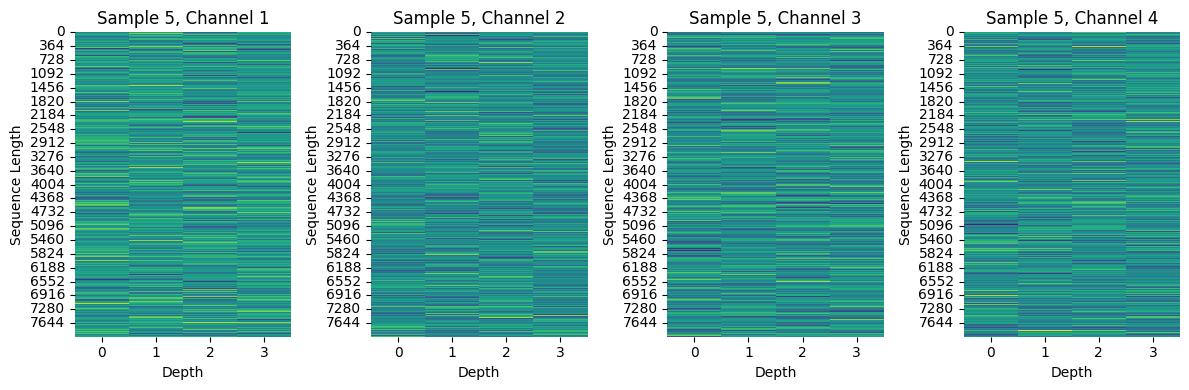

In [57]:
visualize_generated_samples(generator, 100)

In [2]:
len(tf.config.list_physical_devices('GPU'))

1

In [3]:
tf.__version__

'2.18.0'